In [6]:
import hashlib
import os
import tarfile
import zipfile
import  requests

DATA_HUB = dict()
DATA_URL = 'http://d2l-data.s3-accelerate.amazonaws.com/'


def download(name, cache_dir=os.path.join('..', 'data')):
    """下载一个DATA_HUB中的文件，返回本地文件名。"""
    assert name in DATA_HUB, f"{name} 不存在于 {DATA_HUB}."
    url, sha1_hash = DATA_HUB[name]
    os.makedirs(cache_dir, exist_ok=True)
    fname = os.path.join(cache_dir, url.split('/')[-1])
    if os.path.exists(fname):
        sha1 = hashlib.sha1()
        with open(fname, 'rb') as f:
            while True:
                data = f.read(1048576)
                if not data:
                    break
                sha1.update(data)
        if sha1.hexdigest() == sha1_hash:
            return fname
    print(f'正在从{url}下载{fname}...')
    r = requests.get(url, stream=True, verify=True)
    with open(fname, 'wb') as f:
        f.write(r.content)
    return fname
def download_extract(name, folder=None):
    """下载并解压zip/tar文件。"""
    fname = download(name)
    base_dir = os.path.dirname(fname)
    data_dir, ext = os.path.splitext(fname)
    if ext == '.zip':
        fp = zipfile.ZipFile(fname, 'r')
    elif ext in ('.tar', '.gz'):
        fp = tarfile.open(fname, 'r')
    else:
        assert False, '只有zip/tar文件可以被解压缩。'
    fp.extractall(base_dir)
    return os.path.join(base_dir, folder) if folder else data_dir
def download_all():
    """下载DATA_HUB中的所有文件。"""
    for name in DATA_HUB:
        download(name)

In [7]:
import numpy as np
import pandas as pd
import torch
from torch import nn
from d2l import torch as d2l

DATA_HUB['kaggle_house_train'] = (
    DATA_URL + 'kaggle_house_pred_train.csv',
    '585e9cc93e70b39160e7921475f9bcd7d31219ce')
DATA_HUB['kaggle_house_test'] = (
    DATA_URL + 'kaggle_house_pred_test.csv',
    'fa19780a7b011d9b009e8bff8e99922a8ee2eb90')

train_data = pd.read_csv(download('kaggle_house_train'))
test_data = pd.read_csv(download('kaggle_house_test'))

In [9]:
# print(train_data.shape)
# 第一个特征ID去掉
all_features = pd.concat((train_data.iloc[:,1:-1],test_data.iloc[:,1:]))
numeric_features = all_features.dtypes[all_features.dtypes!='object'].index
all_features[numeric_features] = all_features[numeric_features].apply(
    lambda x:(x-x.mean())/(x.std()))
all_features[numeric_features] = all_features[numeric_features].fillna(0) # 缺失值变为0
# 处理离散文本，用独热编码代替
all_features = pd.get_dummies(all_features,dummy_na=True)

n_train = train_data.shape[0]
train_features = torch.tensor(all_features[:n_train].values,
                              dtype=torch.float32)
test_features = torch.tensor(all_features[n_train:].values,
                             dtype=torch.float32)
train_labels = torch.tensor(train_data.SalePrice.values.reshape(-1,1),
                            dtype=torch.float32)

fold 1, train log rmse 0.162217, valid log rmse 0.191047
fold 2, train log rmse 0.162305, valid log rmse 0.188992
fold 3, train log rmse 0.162333, valid log rmse 0.191331
fold 4, train log rmse 0.162091, valid log rmse 0.191800
fold 5, train log rmse 0.162481, valid log rmse 0.192077
5-折验证: 平均训练log rmse: 0.162285, 平均验证log rmse: 0.191049


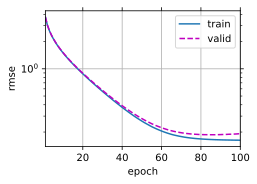

In [10]:
# 训练
loss = nn.MSELoss()
in_features = train_features.shape[1]
def get_net():
    net = nn.Sequential(nn.Linear(in_features,1))
    return net
def log_rmse(net,features,labels):# 对于大的值，使用log函数
    clipped_preds = torch.clamp(net(features),1,float('inf')) # 将inf变为1
    rmse = torch.sqrt(loss(torch.log(clipped_preds),torch.log(labels)))
    return rmse.item()
def train(net,train_features,train_labels,test_features,test_labels,
          num_epochs,learning_rate,weight_decay,batch_size):
    train_ls, test_ls = [], []
    train_iter = d2l.load_array((train_features,train_labels),batch_size)
    optimizer = torch.optim.Adam(net.parameters(),lr=learning_rate,
                                 weight_decay=weight_decay)

    for epoch in range(num_epochs):
        for X,y in train_iter:
            optimizer.zero_grad()
            l = loss(net(X),y)
            l.backward()
            optimizer.step()

        train_ls.append(log_rmse(net, train_features, train_labels))
        if test_labels is not None:
            test_ls.append(log_rmse(net, test_features, test_labels))
    return train_ls, test_ls
def get_k_fold_data(k,i,X,y):
    assert k > 1
    fold_size = X.shape[0]//k
    X_train, y_train = None,None
    for j in range(k):
        idx = slice(j*fold_size,(j+1)*fold_size)
        X_part, y_part = X[idx,:],y[idx]
        if j==1:
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            X_train = torch.cat([X_train,X_part],0)
            y_train = torch.cat([y_train,y_part],0)
    return X_train,y_train,X_valid,y_valid
def k_fold(k,X_train,y_train,num_epochs,learning_rate,weight_decay,
           batch_size):
    train_l_sum, valid_l_sum = 0,0
    for i in range(k):
        data = get_k_fold_data(k,i,X_train,y_train)
        net = get_net()
        train_ls, valid_ls = train(net,*data,num_epochs,learning_rate,
                                   weight_decay,batch_size)
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]

        if i == 0:
            d2l.plot(list(range(1, num_epochs + 1)), [train_ls, valid_ls],
                     xlabel='epoch', ylabel='rmse', xlim=[1, num_epochs],
                     legend=['train', 'valid'], yscale='log')
        print(f'fold {i + 1}, train log rmse {float(train_ls[-1]):f}, '
              f'valid log rmse {float(valid_ls[-1]):f}')
    return train_l_sum / k, valid_l_sum / k

k, num_epochs, lr, weight_decay, batch_size = 5, 100, 5, 0, 64
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr,
                          weight_decay, batch_size)
print(f'{k}-折验证: 平均训练log rmse: {float(train_l):f}, '
      f'平均验证log rmse: {float(valid_l):f}')